In [1]:
# Cell 1: Imports and Data Preparation
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt
import warnings

print("--- Cell 1: Loading and Preparing Data ---")
warnings.filterwarnings("ignore", category=UserWarning)

try:
    file_path = '../data/cfb_box-scores_2002-2024.csv'
    df = pd.read_csv(file_path)
    print("✅ Successfully loaded the dataset.")
except FileNotFoundError:
    print("❌ Error: Data file not found. Please ensure 'cfb_box-scores_2002-2024.csv' is in the same folder.")
    # In a real notebook, you would stop here. For this example, we create a dummy df to avoid errors.
    # In your environment, this script will exit if the file is not found.
    exit()

df = df[df['season'] >= 2004].copy()
name_mapping = {
    'UConn': 'Connecticut', 'UL Monroe': 'Louisiana Monroe',
    'UTEP': 'Texas El Paso', 'UTSA': 'Texas San Antonio', 'UAB': 'Alabama Birmingham'
}
df['home'] = df['home'].replace(name_mapping)
df['away'] = df['away'].replace(name_mapping)

regular_season_df = df[df['game_type'] == 'regular'].copy()
bowl_games_df = df[df['game_type'] != 'regular'].copy()

# Calculate average offensive and defensive stats
home_stats_off = regular_season_df.rename(columns={'home': 'team', 'score_home': 'points_for', 'pass_yards_home': 'pass_yards_for', 'rush_yards_home': 'rush_yards_for'})
away_stats_off = regular_season_df.rename(columns={'away': 'team', 'score_away': 'points_for', 'pass_yards_away': 'pass_yards_for', 'rush_yards_away': 'rush_yards_for'})
off_cols = ['season', 'team', 'points_for', 'pass_yards_for', 'rush_yards_for']
avg_off_stats = pd.concat([home_stats_off[off_cols], away_stats_off[off_cols]]).groupby(['season', 'team']).mean()

home_stats_def = regular_season_df.rename(columns={'home': 'team', 'score_away': 'points_against', 'pass_yards_away': 'pass_yards_against', 'rush_yards_away': 'rush_yards_against'})
away_stats_def = regular_season_df.rename(columns={'away': 'team', 'score_home': 'points_against', 'pass_yards_home': 'pass_yards_against', 'rush_yards_home': 'rush_yards_against'})
def_cols = ['season', 'team', 'points_against', 'pass_yards_against', 'rush_yards_against']
avg_def_stats = pd.concat([home_stats_def[def_cols], away_stats_def[def_cols]]).groupby(['season', 'team']).mean()

season_avg_stats = pd.merge(avg_off_stats, avg_def_stats, on=['season', 'team']).reset_index()

# Create the modeling DataFrame
modeling_data = []
for index, row in bowl_games_df.iterrows():
    season, home_team, away_team = row['season'], row['home'], row['away']
    home_stats = season_avg_stats[(season_avg_stats['season'] == season) & (season_avg_stats['team'] == home_team)]
    away_stats = season_avg_stats[(season_avg_stats['season'] == season) & (season_avg_stats['team'] == away_team)]
    if not home_stats.empty and not away_stats.empty:
        game_dict = { 'season': season }
        game_dict.update({f'H_O_{stat}': home_stats[f'{stat}_for'].values[0] for stat in ['points', 'pass_yards', 'rush_yards']})
        game_dict.update({f'A_D_{stat}': away_stats[f'{stat}_against'].values[0] for stat in ['points', 'pass_yards', 'rush_yards']})
        game_dict.update({f'A_O_{stat}': away_stats[f'{stat}_for'].values[0] for stat in ['points', 'pass_yards', 'rush_yards']})
        game_dict.update({f'H_D_{stat}': home_stats[f'{stat}_against'].values[0] for stat in ['points', 'pass_yards', 'rush_yards']})
        game_dict.update({'score_home': row['score_home'], 'score_away': row['score_away'], 'winner': 1 if row['score_home'] > row['score_away'] else 0})
        modeling_data.append(game_dict)

modeling_df = pd.DataFrame(modeling_data)
print("✅ Modeling DataFrame created.")

# Initialize dictionaries to store results across cells
seasons = sorted(modeling_df['season'].unique())[:11]
results = {model_name: {'score_mses': [], 'winner_mses': []} for model_name in ['LR_Baseline', 'LR_FeatureSelection', 'SVM_Regression', 'SVM_Classification', 'Logistic_Baseline', 'Logistic_FeatureSelection']}
seasonal_accuracies = {model_name: [] for model_name in ['LR Baseline', 'LR with Feature Selection', 'SVM', 'Logistic Regression Baseline', 'Logistic Regression Reduced Features']}
print("✅ Setup complete. Ready for experiments.")

--- Cell 1: Loading and Preparing Data ---
✅ Successfully loaded the dataset.
✅ Modeling DataFrame created.
✅ Setup complete. Ready for experiments.


In [2]:
# Cell 2: Feature Selection
print("\n--- Cell 2: Performing Feature Selection ---")

all_features = [col for col in modeling_df.columns if '_O_' in col or '_D_' in col]

# Find best features for score prediction
sfs_scorer = SequentialFeatureSelector(LinearRegression(), n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error', cv=5, tol=None)
sfs_scorer.fit(modeling_df[all_features], modeling_df['score_home'])
selected_score_features = list(np.array(all_features)[sfs_scorer.get_support()])

# Find best features for winner classification
sfs_classifier = SequentialFeatureSelector(LogisticRegression(), n_features_to_select='auto', direction='forward', scoring='accuracy', cv=5, tol=None)
sfs_classifier.fit(modeling_df[all_features], modeling_df['winner'])
selected_classification_features = list(np.array(all_features)[sfs_classifier.get_support()])

print(f"✅ Selected {len(selected_score_features)} features for Score Regression: {selected_score_features}")
print(f"✅ Selected {len(selected_classification_features)} features for Logistic Regression: {selected_classification_features}")


--- Cell 2: Performing Feature Selection ---
✅ Selected 6 features for Score Regression: [np.str_('H_O_points'), np.str_('A_D_points'), np.str_('A_D_rush_yards'), np.str_('H_D_points'), np.str_('H_D_pass_yards'), np.str_('H_D_rush_yards')]
✅ Selected 6 features for Logistic Regression: [np.str_('A_D_points'), np.str_('A_D_rush_yards'), np.str_('A_O_points'), np.str_('A_O_rush_yards'), np.str_('H_D_pass_yards'), np.str_('H_D_rush_yards')]


In [3]:
# Cell 3: Experiment 1 - Linear Regression Models
print("\n--- Cell 3: Running Linear Regression Experiments ---")

# Define feature sets for this experiment
home_features_baseline = ['H_O_points', 'H_O_pass_yards', 'H_O_rush_yards', 'A_D_points', 'A_D_pass_yards', 'A_D_rush_yards']
away_features_baseline = ['A_O_points', 'A_O_pass_yards', 'A_O_rush_yards', 'H_D_points', 'H_D_pass_yards', 'H_D_rush_yards']

for test_season in seasons:
    train_df = modeling_df[(modeling_df['season'] != test_season) & (modeling_df['season'].isin(seasons))]
    test_df = modeling_df[modeling_df['season'] == test_season]

    # Baseline Model
    lr_home = LinearRegression().fit(train_df[home_features_baseline], train_df['score_home'])
    lr_away = LinearRegression().fit(train_df[away_features_baseline], train_df['score_away'])
    pred_h = lr_home.predict(test_df[home_features_baseline])
    pred_a = lr_away.predict(test_df[away_features_baseline])
    acc_lr_base = accuracy_score(test_df['winner'], (pred_h > pred_a).astype(int))
    seasonal_accuracies['LR Baseline'].append(acc_lr_base)
    results['LR_Baseline']['score_mses'].append((mean_squared_error(test_df['score_home'], pred_h) + mean_squared_error(test_df['score_away'], pred_a)) / 2)
    results['LR_Baseline']['winner_mses'].append(1 - acc_lr_base)

    # Feature Selection Model
    lr_home_fs = LinearRegression().fit(train_df[selected_score_features], train_df['score_home'])
    lr_away_fs = LinearRegression().fit(train_df[selected_score_features], train_df['score_away'])
    pred_h_fs = lr_home_fs.predict(test_df[selected_score_features])
    pred_a_fs = lr_away_fs.predict(test_df[selected_score_features])
    acc_lr_fs = accuracy_score(test_df['winner'], (pred_h_fs > pred_a_fs).astype(int))
    seasonal_accuracies['LR with Feature Selection'].append(acc_lr_fs)
    results['LR_FeatureSelection']['score_mses'].append((mean_squared_error(test_df['score_home'], pred_h_fs) + mean_squared_error(test_df['score_away'], pred_a_fs)) / 2)
    results['LR_FeatureSelection']['winner_mses'].append(1 - acc_lr_fs)

print("✅ Linear Regression experiments complete.")


--- Cell 3: Running Linear Regression Experiments ---
✅ Linear Regression experiments complete.


In [4]:
# Cell 4: Experiment 2 - SVM Models
print("\n--- Cell 4: Running SVM Experiments ---")

for test_season in seasons:
    train_df = modeling_df[(modeling_df['season'] != test_season) & (modeling_df['season'].isin(seasons))]
    test_df = modeling_df[modeling_df['season'] == test_season]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_df[all_features])
    X_test_scaled = scaler.transform(test_df[all_features])

    # SVR for Score Regression
    svr_home = SVR().fit(X_train_scaled, train_df['score_home'])
    svr_away = SVR().fit(X_train_scaled, train_df['score_away'])
    pred_h_svr = svr_home.predict(X_test_scaled)
    pred_a_svr = svr_away.predict(X_test_scaled)
    results['SVM_Regression']['score_mses'].append((mean_squared_error(test_df['score_home'], pred_h_svr) + mean_squared_error(test_df['score_away'], pred_a_svr)) / 2)
    results['SVM_Regression']['winner_mses'].append(1 - accuracy_score(test_df['winner'], (pred_h_svr > pred_a_svr).astype(int)))

    # SVC for Winner Classification (used for the plot)
    svc = SVC(probability=True).fit(X_train_scaled, train_df['winner'])
    pred_svc = svc.predict(X_test_scaled)
    acc_svm = accuracy_score(test_df['winner'], pred_svc)
    seasonal_accuracies['SVM'].append(acc_svm)
    results['SVM_Classification']['winner_mses'].append(1 - acc_svm)

print("✅ SVM experiments complete.")


--- Cell 4: Running SVM Experiments ---
✅ SVM experiments complete.


In [5]:
# Cell 5: Experiment 3 - Logistic Regression Models
print("\n--- Cell 5: Running Logistic Regression Experiments ---")

for test_season in seasons:
    train_df = modeling_df[(modeling_df['season'] != test_season) & (modeling_df['season'].isin(seasons))]
    test_df = modeling_df[modeling_df['season'] == test_season]

    scaler = StandardScaler()

    # Baseline Model
    X_train_scaled = scaler.fit_transform(train_df[all_features])
    X_test_scaled = scaler.transform(test_df[all_features])
    log_reg = LogisticRegression(max_iter=1000).fit(X_train_scaled, train_df['winner'])
    pred_log = log_reg.predict(X_test_scaled)
    acc_log_base = accuracy_score(test_df['winner'], pred_log)
    seasonal_accuracies['Logistic Regression Baseline'].append(acc_log_base)
    results['Logistic_Baseline']['winner_mses'].append(1 - acc_log_base)

    # Feature Selection Model
    X_train_scaled_fs = scaler.fit_transform(train_df[selected_classification_features])
    X_test_scaled_fs = scaler.transform(test_df[selected_classification_features])
    log_reg_fs = LogisticRegression(max_iter=1000).fit(X_train_scaled_fs, train_df['winner'])
    pred_log_fs = log_reg_fs.predict(X_test_scaled_fs)
    acc_log_fs = accuracy_score(test_df['winner'], pred_log_fs)
    seasonal_accuracies['Logistic Regression Reduced Features'].append(acc_log_fs)
    results['Logistic_FeatureSelection']['winner_mses'].append(1 - acc_log_fs)

print("✅ Logistic Regression experiments complete.")


--- Cell 5: Running Logistic Regression Experiments ---
✅ Logistic Regression experiments complete.


In [6]:
# Cell 6: Final Results Summary
print("\n" + "="*50)
print("           FINAL CROSS-VALIDATION RESULTS")
print("="*50)

print("\n--- Linear Regression ---")
print(f"Baseline -> Avg Score MSE: {np.mean(results['LR_Baseline']['score_mses']):.2f}, Avg Winner MSE: {np.mean(results['LR_Baseline']['winner_mses']):.4f}")
print(f"Feature Selection -> Avg Score MSE: {np.mean(results['LR_FeatureSelection']['score_mses']):.2f}, Avg Winner MSE: {np.mean(results['LR_FeatureSelection']['winner_mses']):.4f}")

print("\n--- Support Vector Machine (SVM) ---")
print(f"Score Regression (SVR) -> Avg Score MSE: {np.mean(results['SVM_Regression']['score_mses']):.2f}, Avg Winner MSE: {np.mean(results['SVM_Regression']['winner_mses']):.4f}")
print(f"Winner Classification (SVC) -> Avg Winner MSE: {np.mean(results['SVM_Classification']['winner_mses']):.4f}")

print("\n--- Logistic Regression ---")
print(f"Baseline -> Avg Winner MSE: {np.mean(results['Logistic_Baseline']['winner_mses']):.4f}")
print(f"Feature Selection -> Avg Winner MSE: {np.mean(results['Logistic_FeatureSelection']['winner_mses']):.4f}")
print("="*50)


           FINAL CROSS-VALIDATION RESULTS

--- Linear Regression ---
Baseline -> Avg Score MSE: 134.50, Avg Winner MSE: 0.4287
Feature Selection -> Avg Score MSE: 137.94, Avg Winner MSE: 0.4427

--- Support Vector Machine (SVM) ---
Score Regression (SVR) -> Avg Score MSE: 140.63, Avg Winner MSE: 0.4459
Winner Classification (SVC) -> Avg Winner MSE: 0.4501

--- Logistic Regression ---
Baseline -> Avg Winner MSE: 0.4488
Feature Selection -> Avg Winner MSE: 0.4191



✅ Generating accuracy plot...


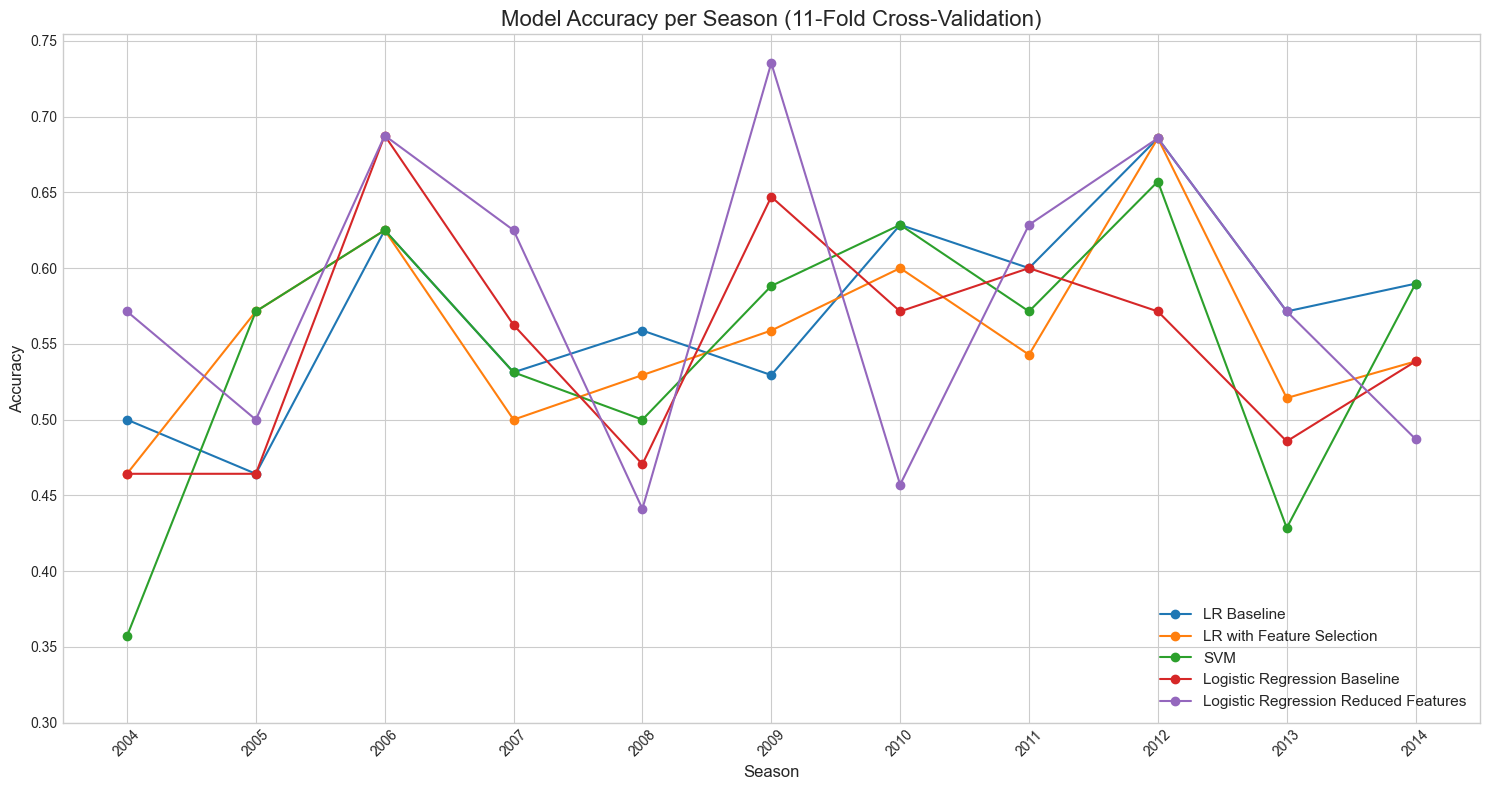

In [7]:
# Cell 7: Plot Results
print("\n✅ Generating accuracy plot...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 8))

for model_name, acc_list in seasonal_accuracies.items():
    plt.plot(seasons, acc_list, marker='o', linestyle='-', label=model_name)

plt.title('Model Accuracy per Season (11-Fold Cross-Validation)', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(seasons, rotation=45)
plt.yticks(np.arange(0.30, 0.80, 0.05)) # Adjusted y-axis for better visibility
plt.legend(fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()